# Click-Through Rate Prediction Lab

## Part 1: Featurize categorical data using one-hot-encoding

### (1a) One-hot-encoding

In [1]:
# By default, when a shuffle operation occurs with DataFrames, the post-shuffle partition
# count is 200. This is controlled by Spark configuration value spark.sql.shuffle.partitions.
# 200 is a little too high for this data set, so we set the post-shuffle partition count to
# twice the number of available threads in Community Edition.
sqlContext.setConf('spark.sql.shuffle.partitions', '6')  # Set default partitions for DataFrame operations

In [2]:
from collections import defaultdict
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sample_one = [(0, 'mouse'), (1, 'black')]
sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

def sample_to_row(sample):
    tmp_dict = defaultdict(lambda: None)
    tmp_dict.update(sample)
    return [tmp_dict[i] for i in range(3)]

sqlContext.createDataFrame(map(sample_to_row, [sample_one, sample_two, sample_three]),
                           ['animal', 'color', 'food']).show()
sample_data_df = sqlContext.createDataFrame([(sample_one,), (sample_two,), (sample_three,)], ['features'])
sample_data_df.show(truncate=False)

+------+-----+------+
|animal|color|  food|
+------+-----+------+
| mouse|black|  null|
|   cat|tabby| mouse|
|  bear|black|salmon|
+------+-----+------+

+---------------------------------+
|features                         |
+---------------------------------+
|[[0,mouse], [1,black]]           |
|[[0,cat], [1,tabby], [2,mouse]]  |
|[[0,bear], [1,black], [2,salmon]]|
+---------------------------------+



In [3]:
sample_ohe_dict_manual = {}
sample_ohe_dict_manual[(0, 'bear')] = 0
sample_ohe_dict_manual[(0, 'cat')] = 1
sample_ohe_dict_manual[(0, 'mouse')] = 2
sample_ohe_dict_manual[(1, 'black')] = 3
sample_ohe_dict_manual[(1, 'tabby')] = 4
sample_ohe_dict_manual[(2, 'mouse')] = 5
sample_ohe_dict_manual[(2, 'salmon')] = 6

### (1b) Sparse vectors

In [4]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

a_dense = np.array([0., 3., 0., 4.])
a_sparse = SparseVector(4, [1,3], [3,4])

b_dense = np.array([0., 0., 0., 1.])
b_sparse = SparseVector(4, [(3,1)])

w = np.array([0.4, 3.1, -1.4, -.5])
print(a_dense.dot(w))
print(a_sparse.dot(w))
print(b_dense.dot(w))
print(b_sparse.dot(w))

7.3
7.3
-0.5
-0.5


### (1c) OHE features as sparse vectors

In [5]:
# Reminder of the sample features
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [6]:
sample_one_ohe_feat_manual = SparseVector(7, [(2,1), (3,1)])
sample_two_ohe_feat_manual = SparseVector(7, [(1,1), (4,1), (5,1)])
sample_three_ohe_feat_manual = SparseVector(7, [(0,1), (3,1), (6,1)])

### (1d) Define a OHE function

In [7]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    result = []
    for feat in raw_feats:
      result.append((ohe_dict_broadcast.value[feat],1))
    return SparseVector(num_ohe_feats, result)

# Calculate the number of features in sample_ohe_dict_manual
num_sample_ohe_feats = len(sample_ohe_dict_manual)
sample_ohe_dict_manual_broadcast = sc.broadcast(sample_ohe_dict_manual)

# Run one_hot_encoding() on sample_one.  Make sure to pass in the Broadcast variable.
sample_one_ohe_feat = one_hot_encoding(sample_one, sample_ohe_dict_manual_broadcast, num_sample_ohe_feats)

print(sample_one_ohe_feat)

(7,[2,3],[1.0,1.0])


### (1e) Apply OHE to a dataset

In [8]:
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import VectorUDT

def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())

sample_ohe_dict_udf = ohe_udf_generator(sample_ohe_dict_manual_broadcast)
sample_ohe_df = sample_data_df.select(sample_ohe_dict_udf('features'))
sample_ohe_df.show(truncate=False)

+-------------------------+
|<lambda>(features)       |
+-------------------------+
|(7,[2,3],[1.0,1.0])      |
|(7,[1,4,5],[1.0,1.0,1.0])|
|(7,[0,3,6],[1.0,1.0,1.0])|
+-------------------------+



## Part 2: Construct an OHE dictionary

### (2a) DataFrame with rows of `(featureID, category)`

In [9]:
from pyspark.sql.functions import explode
sample_distinct_feats_df = (sample_data_df
                              .select(explode('features'))
                              .distinct())
sample_distinct_feats_df.show()

+----------+
|       col|
+----------+
|   [0,cat]|
| [0,mouse]|
| [1,black]|
| [2,mouse]|
|[2,salmon]|
|  [0,bear]|
| [1,tabby]|
+----------+



### (2b) OHE Dictionary from distinct features

In [10]:
sample_ohe_dict = (sample_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex()
                     .collectAsMap())
print(sample_ohe_dict)

{(2, u'mouse'): 3, (0, u'cat'): 0, (0, u'bear'): 5, (2, u'salmon'): 4, (1, u'tabby'): 6, (1, u'black'): 2, (0, u'mouse'): 1}


### (2c) Automated creation of an OHE dictionary

In [11]:
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    return (input_df.select(explode('features')).distinct().rdd
                    .map(lambda r: tuple(r[0]))
                    .zipWithIndex()
                    .collectAsMap())

sample_ohe_dict_auto = create_one_hot_dict(sample_data_df)

## Part 3: Parse CTR data and generate OHE features

```python
import tarfile
import tempfile

tar_file_name = 'path/to/file/dac_sample.tar.gz'
tf = tarfile.open(tar_file_name)
dac_sample = tf.extractfile('dac_sample.txt')
dac_sample = '\n'.join([unicode(x.replace('\n','').replace('\t',',')) for x in dac_sample])

with tempfile.NamedTemporaryFile(mode='wb', delete=False, prefix='dac', suffix='txt') as t:
    t.write(dac_sample)
    t.close()
```

In [12]:
raw_df = sqlContext.read.text('dac_sample.txt').withColumnRenamed('value', 'text')
raw_df.show()

+--------------------+
|                text|
+--------------------+
|0,1,1,5,0,1382,4,...|
|0,2,0,44,1,102,8,...|
|0,2,0,1,14,767,89...|
|0,,893,,,4392,,0,...|
|0,3,-1,,0,2,0,3,0...|
|0,,-1,,,12824,,0,...|
|0,,1,2,,3168,,0,1...|
|1,1,4,2,0,0,0,1,0...|
|0,,44,4,8,19010,2...|
|0,,35,,1,33737,21...|
|0,,2,632,0,56770,...|
|0,0,6,6,6,421,109...|
|1,0,-1,,,1465,0,1...|
|1,,2,11,5,10262,3...|
|0,0,51,84,4,3633,...|
|0,,2,1,18,20255,,...|
|1,1,987,,2,105,2,...|
|0,0,1,,0,16597,55...|
|0,0,24,4,2,2056,1...|
|0,7,102,,3,780,15...|
+--------------------+
only showing top 20 rows



### (3a) Loading and splitting the data

In [13]:
weights = [.8, .1, .1]
seed = 42

# Use randomSplit with weights and seed
raw_train_df, raw_validation_df, raw_test_df = raw_df.randomSplit(weights, seed)

# Cache and count the DataFrames
n_train = raw_train_df.cache().count()
n_val = raw_validation_df.cache().count()
n_test = raw_test_df.cache().count()
print(n_train, n_val, n_test, n_train + n_val + n_test)
raw_df.show(1)

(80115, 9955, 9930, 100000)
+--------------------+
|                text|
+--------------------+
|0,1,1,5,0,1382,4,...|
+--------------------+
only showing top 1 row



### (3b) Extract features

In [14]:
def parse_point(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    features = point.split(',')[1:]
    indexed_features = []
    for i in range(len(features)):
      indexed_features.append((i, features[i]))
    return indexed_features

print(parse_point(raw_df.select('text').first()[0]))

[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')]


### (3c) Extracting features continued

In [15]:
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, DoubleType

parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.


    Args:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.
    """
    return raw_df.select(split('text', ',').getItem(0).cast("double").alias("label"), parse_point_udf('text').alias('feature')).cache()

# Parse the raw training DataFrame
parsed_train_df = parse_raw_df(raw_train_df)

from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                    .select(explode('feature').alias('feature'))
                    .distinct()
                    .select(col('feature').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

print(num_categories[2][1])

1720


### (3d) Create an OHE dictionary from the dataset

In [16]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df.select(col("feature").alias("features")))
num_ctr_ohe_feats = len(ctr_ohe_dict)
print(num_ctr_ohe_feats)
print(ctr_ohe_dict[(0, '')])

233618
0


### (3e) Apply OHE to the dataset

In [17]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf = ohe_udf_generator(ohe_dict_broadcast)
ohe_train_df = (parsed_train_df
                  .select("label",ohe_dict_udf('feature').alias("features"))).cache()

print(ohe_train_df.count())
print(ohe_train_df.take(1))

80115
[Row(label=0.0, features=SparseVector(233618, {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 38954: 1.0, 38955: 1.0, 38956: 1.0, 38957: 1.0, 38958: 1.0, 78081: 1.0, 78082: 1.0, 78083: 1.0, 78084: 1.0, 78085: 1.0, 78086: 1.0, 78087: 1.0, 78088: 1.0, 116967: 1.0, 116968: 1.0, 116969: 1.0, 116970: 1.0, 116971: 1.0, 155898: 1.0, 155899: 1.0, 155900: 1.0, 155901: 1.0, 155902: 1.0, 194626: 1.0, 194627: 1.0, 194628: 1.0, 194629: 1.0, 194630: 1.0, 194631: 1.0, 194632: 1.0, 194633: 1.0, 194634: 1.0}))]


### Visualization 1: Feature frequency

In [18]:
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import log

get_indices = udf(lambda sv: map(int, sv.indices), ArrayType(IntegerType()))
feature_counts = (ohe_train_df
                   .select(explode(get_indices('features')))
                   .groupBy('col')
                   .count()
                   .withColumn('bucket', log('count').cast('int'))
                   .groupBy('bucket')
                   .count()
                   .orderBy('bucket')
                   .collect())

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


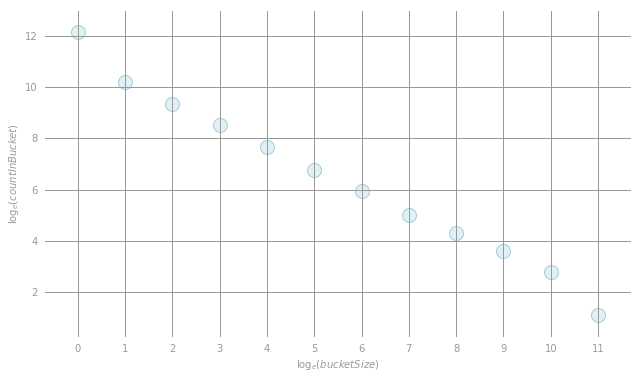

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
x, y = zip(*feature_counts)
x, y = x, np.log(y)

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 12, 1), np.arange(0, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
fig.show()

### (3f) Handling unseen features

In [20]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    result = []
    for feat in raw_feats:
        if feat in ohe_dict_broadcast.value:
            result.append((ohe_dict_broadcast.value[feat],1))
    return SparseVector(num_ohe_feats, result)
  
def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())

ohe_dict_missing_udf = ohe_udf_generator(ohe_dict_broadcast)
ohe_validation_df = (parse_raw_df(raw_validation_df)
                        .select("label",ohe_dict_missing_udf('feature').alias("features"))).cache()

ohe_validation_df.count()
ohe_validation_df.show(1, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                              |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part 4: CTR prediction and logloss evaluation

### (4a) Logistic regression

In [21]:
standardization = False
elastic_net_param = 0.0
reg_param = .01
max_iter = 20

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors as MLVectors

ohe_train_ml_vectors_df = (ohe_train_df
                           .rdd.map(lambda x : 
                            (x['label'], MLVectors.sparse(x['features'].size, list(x['features'].indices), list(x['features'].values))))
                           .toDF(['label','features']))

lr = LogisticRegression(standardization = standardization, elasticNetParam = elastic_net_param, regParam = reg_param, maxIter = max_iter)

lr_model_basic = lr.fit(ohe_train_ml_vectors_df)

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]

intercept: -1.22762492787
length of coefficients: 233618


### (4b) Log loss

In [22]:
example_log_loss_df = sqlContext.createDataFrame([(.5, 1), (.5, 0), (.99, 1), (.99, 0), (.01, 1),
                                                  (.01, 0), (1., 1), (.0, 1), (1., 0)], ['p', 'label'])
example_log_loss_df.show()

+----+-----+
|   p|label|
+----+-----+
| 0.5|    1|
| 0.5|    0|
|0.99|    1|
|0.99|    0|
|0.01|    1|
|0.01|    0|
| 1.0|    1|
| 0.0|    1|
| 1.0|    0|
+----+-----+



In [23]:
from pyspark.sql.functions import when, log, col, lit
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    return df.withColumn("log_loss", when(df.label == 1, lit(-1) * log(when(df.p == 0, df.p + epsilon).when(df.p == 1, df.p - epsilon).otherwise(df.p))).otherwise(-1 * log(lit(1)- when(df.p == 0, df.p + epsilon).when(df.p == 1, df.p - epsilon).otherwise(df.p))))

add_log_loss(example_log_loss_df).show()

+----+-----+--------------------+
|   p|label|            log_loss|
+----+-----+--------------------+
| 0.5|    1|  0.6931471805599453|
| 0.5|    0|  0.6931471805599453|
|0.99|    1| 0.01005033585350145|
|0.99|    0|   4.605170185988091|
|0.01|    1|   4.605170185988091|
|0.01|    0| 0.01005033585350145|
| 1.0|    1|1.110223024625156...|
| 0.0|    1|  36.841361487904734|
| 1.0|    0|    36.7368005696771|
+----+-----+--------------------+



### (4c) Baseline log loss

In [24]:
from pyspark.sql.functions import lit, avg
class_one_frac_train = (ohe_train_df.groupBy().avg("label")).head()[0]
print('Training class one fraction = {0:.3f}'.format(class_one_frac_train))

log_loss_tr_base = add_log_loss(ohe_train_df.withColumn("p",lit(class_one_frac_train))).groupBy().avg("log_loss").head()[0]
#print 'Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base)

Training class one fraction = 0.227


### (4d) Predicted probability

In [25]:
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model"""
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            features: the features

        Returns:
            float: A probability between 0 and 1.
        """
        # Compute the raw value
        raw_prediction = features.dot(coefficients_broadcast.value) + intercept
        # Bound the raw value between 20 and -20
        raw_prediction = 20 if raw_prediction > 20 else -20 if raw_prediction < -20 else raw_prediction
        # Return the probability
        return 1/(1+exp(-raw_prediction))

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))
#print lr_model_basic.coefficients
add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_ml_vectors_df).cache()

training_predictions.show(5)

+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(233618,[0,1,2,3,...| 0.1518925746082389|
|  0.0|(233618,[0,1,4,6,...|  0.130251666006613|
|  0.0|(233618,[0,1,4,6,...|0.12389289405670015|
|  0.0|(233618,[0,1,4,6,...|0.12651427318693748|
|  0.0|(233618,[0,1,4,6,...|0.11079476120915072|
+-----+--------------------+-------------------+
only showing top 5 rows



### (4e) Evaluate the model

In [26]:
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.

    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.

    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.

    Returns:
        float: Log loss for the data.
    """
    with_probability_df = add_probability(df, model) if not baseline else df.withColumn("p",lit(baseline))
    with_log_loss_df = add_log_loss(with_probability_df)
    log_loss = with_log_loss_df.groupBy().avg("log_loss").head()[0]
    return log_loss

log_loss_train_model_basic = evaluate_results(ohe_train_ml_vectors_df, lr_model_basic)
print('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))

OHE Features Train Logloss:
	Baseline = 0.535
	LogReg = 0.474


### (4f) Validation log loss

In [27]:
ohe_validation_ml_vectors_df = (ohe_validation_df
                               .rdd.map(lambda x : 
                                (x['label'], MLVectors.sparse(x['features'].size, list(x['features'].indices), list(x['features'].values))))
                               .toDF(['label','features']))


log_loss_val_base = evaluate_results(ohe_validation_ml_vectors_df, None, class_one_frac_train)

log_loss_val_l_r0 = evaluate_results(ohe_validation_ml_vectors_df, lr_model_basic, None)
print('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_val_base, log_loss_val_l_r0))

OHE Features Validation Logloss:
	Baseline = 0.535
	LogReg = 0.478


### Visualization 2: ROC curve

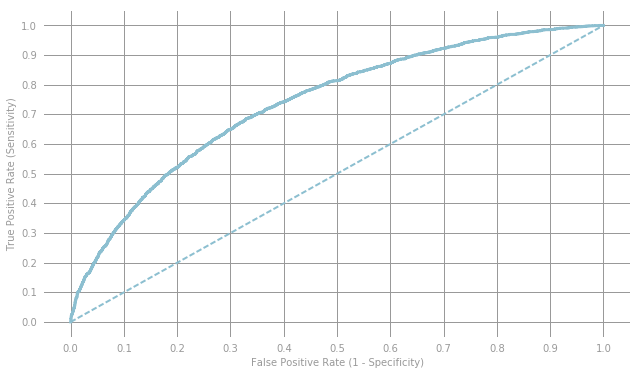

In [28]:
labels_and_scores = add_probability_model_basic(ohe_validation_ml_vectors_df).select('label', 'p')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda (k, v): v, reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

# Generate layout and plot data
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#8cbfd0', linewidth=2.)  # Baseline model
fig.show()

## Part 5: Reduce feature dimension via feature hashing

### (5a) Hash function

In [29]:
from collections import defaultdict
import hashlib

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = { category + ':' + str(ind):
                int(int(hashlib.md5(category + ':' + str(ind)).hexdigest(), 16) % num_buckets)
                for ind, category in raw_feats}
    if(print_mapping): print mapping

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)

# Reminder of the sample values:
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
# TODO: Replace <FILL IN> with appropriate code
# Use four buckets
samp_one_four_buckets = hash_function(sample_one, 4, True)
samp_two_four_buckets = hash_function(sample_two, 4, True)
samp_three_four_buckets = hash_function(sample_three, 4, True)

# Use one hundred buckets
samp_one_hundred_buckets = hash_function(sample_one, 100, True)
samp_two_hundred_buckets = hash_function(sample_two, 100, True)
samp_three_hundred_buckets = hash_function(sample_three, 100, True)

print('\n\t\t 4 Buckets \t\t\t 100 Buckets')
print('SampleOne:\t {0}\t\t\t {1}'.format(samp_one_four_buckets, samp_one_hundred_buckets))
print('SampleTwo:\t {0}\t\t {1}'.format(samp_two_four_buckets, samp_two_hundred_buckets))
print('SampleThree:\t {0}\t {1}'.format(samp_three_four_buckets, samp_three_hundred_buckets))

{'mouse:0': 3, 'black:1': 3}
{'mouse:2': 1, 'tabby:1': 0, 'cat:0': 1}
{'bear:0': 2, 'black:1': 3, 'salmon:2': 0}
{'mouse:0': 99, 'black:1': 51}
{'mouse:2': 9, 'tabby:1': 72, 'cat:0': 21}
{'bear:0': 82, 'black:1': 51, 'salmon:2': 80}

		 4 Buckets 			 100 Buckets
SampleOne:	 {3: 2.0}			 {99: 1.0, 51: 1.0}
SampleTwo:	 {0: 1.0, 1: 2.0}		 {72: 1.0, 9: 1.0, 21: 1.0}
SampleThree:	 {0: 1.0, 2: 1.0, 3: 1.0}	 {80: 1.0, 82: 1.0, 51: 1.0}


### (5b) Creating hashed features

In [30]:
from pyspark.mllib.linalg import Vectors
num_hash_buckets = 2 ** 15

# UDF that returns a vector of hashed features given an Array of tuples
tuples_to_hash_features_udf = udf(lambda x: Vectors.sparse(num_hash_buckets, hash_function(x, num_hash_buckets)), VectorUDT())

def add_hashed_features(df):
    """Return a DataFrame with labels and hashed features.

    Note:
        Make sure to cache the DataFrame that you are returning.

    Args:
        df (DataFrame with 'tuples' column): A DataFrame containing the tuples to be hashed.

    Returns:
        DataFrame: A DataFrame with a 'label' column and a 'features' column that contains a
            SparseVector of hashed features.
    """
    return df.withColumn("features", tuples_to_hash_features_udf("feature")).drop("feature")

hash_train_df = add_hashed_features(parsed_train_df)
hash_validation_df = add_hashed_features(parse_raw_df(raw_validation_df))
hash_test_df = add_hashed_features(parse_raw_df(raw_test_df))

hash_train_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(32768,[1613,1659...|
|  0.0|(32768,[1408,1613...|
|  0.0|(32768,[1613,2034...|
|  0.0|(32768,[351,1613,...|
|  0.0|(32768,[103,492,1...|
|  0.0|(32768,[1613,2034...|
|  0.0|(32768,[340,1408,...|
|  0.0|(32768,[300,1613,...|
|  0.0|(32768,[492,1613,...|
|  0.0|(32768,[492,1613,...|
|  0.0|(32768,[847,881,1...|
|  0.0|(32768,[1408,1597...|
|  0.0|(32768,[1613,2034...|
|  0.0|(32768,[492,1613,...|
|  0.0|(32768,[492,1613,...|
|  0.0|(32768,[1408,1421...|
|  0.0|(32768,[1408,1613...|
|  0.0|(32768,[492,825,1...|
|  0.0|(32768,[170,1613,...|
|  0.0|(32768,[1408,1613...|
+-----+--------------------+
only showing top 20 rows



### (5c) Sparsity

In [31]:
def vector_feature_sparsity(sparse_vector):
    """Calculates the sparsity of a SparseVector.

    Args:
        sparse_vector (SparseVector): The vector containing the features.

    Returns:
        float: The ratio of features found in the vector to the total number of features.
    """
    return float(len(sparse_vector.indices)) / len(sparse_vector)

feature_sparsity_udf = udf(vector_feature_sparsity, DoubleType())

a_sparse_vector = Vectors.sparse(5, {0: 1.0, 3: 1.0})
a_sparse_vector_sparsity = vector_feature_sparsity(a_sparse_vector)
print('This vector should have sparsity 2/5 or .4.')
print('Sparsity = {0:.2f}.'.format(a_sparse_vector_sparsity))

This vector should have sparsity 2/5 or .4.
Sparsity = 0.40.


### (5d) Sparsity continued

In [32]:
feature_sparsity_udf = udf(vector_feature_sparsity, DoubleType())

def get_sparsity(df):
    """Calculates the average sparsity for the features in a DataFrame.

    Args:
        df (DataFrame with 'features' column): A DataFrame with sparse features.

    Returns:
        float: The average feature sparsity.
    """
    return df.select(feature_sparsity_udf("features").alias("s")).groupBy().avg("s").head()[0]

average_sparsity_ohe = get_sparsity(ohe_train_df)
average_sparsity_hash = get_sparsity(hash_train_df)

print('Average OHE Sparsity: {0:.7e}'.format(average_sparsity_ohe))
print('Average Hash Sparsity: {0:.7e}'.format(average_sparsity_hash))

Average OHE Sparsity: 1.6693919e-04
Average Hash Sparsity: 1.1896523e-03


### (5e) Logistic model with hashed features

In [33]:
standardization = False
elastic_net_param = 0.7
reg_param = .001
max_iter = 20

hash_train_ml_vectors_df = (hash_train_df
                               .rdd.map(lambda x : 
                                (x['label'], MLVectors.sparse(x['features'].size, list(x['features'].indices), list(x['features'].values))))
                               .toDF(['label','features']))

lr_hash = (LogisticRegression(standardization = standardization, elasticNetParam = elastic_net_param, regParam = reg_param, maxIter = max_iter))

lr_model_hashed = lr_hash.fit(hash_train_ml_vectors_df)
print('intercept: {0}'.format(lr_model_hashed.intercept))
print(len(lr_model_hashed.coefficients))

log_loss_train_model_hashed = evaluate_results(hash_train_ml_vectors_df, lr_model_hashed, None)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\thashed = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_hashed))

intercept: -1.23541926094
32768
OHE Features Train Logloss:
	Baseline = 0.535
	hashed = 0.466


### (5f) Evaluate on the test set

In [34]:
hash_test_ml_vectors_df = (hash_test_df
                               .rdd.map(lambda x : 
                                (x['label'], MLVectors.sparse(x['features'].size, list(x['features'].indices), list(x['features'].values))))
                               .toDF(['label','features']))

# Log loss for the best model from (5e)
log_loss_test = evaluate_results(hash_test_ml_vectors_df, lr_model_hashed, None)

# Log loss for the baseline model
class_one_frac_test = parse_raw_df(raw_test_df).groupBy().avg("label").head()[0]
print('Class one fraction for test data: {0}'.format(class_one_frac_test))
log_loss_test_baseline = evaluate_results(hash_test_df, lr_model_hashed, class_one_frac_test)

print('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_test_baseline, log_loss_test))

Class one fraction for test data: 0.226183282981
Hashed Features Test Log Loss:
	Baseline = 0.535
	LogReg = 0.470
